# Covid Detection through X-Rays 

## Let us start by making the appropriate imports!

In [57]:
import numpy as np
import pandas as pd
import os
import PIL
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import cv2

## Reading in the data

In [4]:
train_df = pd.read_csv('../input/covidx-cxr2/train.txt', sep=" ", header=None)
train_df.columns=['patient id', 'filename', 'class', 'data source']
train_df=train_df.drop(['patient id', 'data source'], axis=1 )

In [5]:
test_df = pd.read_csv('../input/covidx-cxr2/test.txt', sep=" ", header=None)
test_df.columns=['id', 'filename', 'class', 'data source' ]
test_df=test_df.drop(['id', 'data source'], axis=1 )

In [6]:
train_df.head()

,filename,class
0,ARDSSevere.png,negative
1,acute-respiratory-distress-syndrome-ards-1.jpg,negative
2,acute-respiratory-distress-syndrome-ards.jpg,negative
3,ards-secondary-to-tiger-snake-bite.png,negative
4,pneumocystis-pneumonia-2-PA.png,negative


In [88]:
test_df

,filename,class
0,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive
1,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive
2,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive
3,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive
4,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive
...,...,...
395,a77b32f6-1999-4cc6-8a0d-1ef7e53850f0.png,negative
396,41bf2042-53a2-44a8-9a29-55e643af5ac0.png,negative
397,ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed.png,negative
398,abff4044-3c0a-458f-b0c7-04254be7fc0c.png,negative


## Assign variables to both Train and Test paths

In [9]:
train_path = '../input/covidx-cxr2/train/'
test_path = '../input/covidx-cxr2/test/'
print(train_path)

../input/covidx-cxr2/train/


## Let's look at class counts to see if the classes are unbalanced or balanced..

In [10]:
train_df['class'].value_counts()
# test_df['class'].value_counts()

positive    16490
negative    13992
Name: class, dtype: int64

## They seem balanced

In [11]:
negative  = train_df[train_df['class']=='negative']
positive = train_df[train_df['class']=='positive']

## Let's split the training data into a train set and a validation set

In [12]:
train_df, valid_df = train_test_split(train_df, train_size=0.9, random_state=0)

## Creation of ImageDataGenerator, that first loads images and transforms them to our desire. 

## Here we are using:

### Batch Size = 32, Image width,height = (200,200), Rescale images to restrict image array values between 0 & 1, Color Mode as RGB

In [14]:
batch_size = 32
target_size =(200,200)
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(train_df, 
                                              directory=train_path,
                                              x_col='filename',
                                              y_col='class', 
                                              target_size=target_size, 
                                              batch_size=batch_size, 
                                              color_mode='rgb', 
                                              class_mode='binary')

valid_gen = test_datagen.flow_from_dataframe(valid_df, 
                                             directory=train_path, 
                                             x_col='filename',
                                             y_col='class', 
                                             target_size=target_size, 
                                             batch_size=batch_size, 
                                             color_mode='rgb', 
                                             class_mode='binary')
test_gen = test_datagen.flow_from_dataframe(test_df, 
                                             directory=test_path, 
                                             x_col='filename',
                                             y_col='class', 
                                             target_size=target_size, 
                                             batch_size=batch_size, 
                                             color_mode='rgb', 
                                             class_mode='binary',validate_filenames=False)

Found 27433 validated image filenames belonging to 2 classes.
Found 3049 validated image filenames belonging to 2 classes.


## Let us now create our model & compile it

In [22]:
model2 = Sequential([
  layers.Conv2D(32, 3, padding='same', activation='relu',input_shape=(200,200,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(256, activation='relu'), 
  layers.Dense(2, activation='softmax')
])

In [24]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 128)      

## Let us start training it now!

In [26]:
epochs=10
history2 = model2.fit(
  train_gen,
  validation_data=valid_gen,
  epochs=epochs,
  verbose=1,
)

2021-12-17 21:13:02.263678: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


Epoch 1/10
858/858 [==============================] - 1757s 2s/step - loss: 0.3542 - accuracy: 0.8424 - val_loss: 0.2869 - val_accuracy: 0.8905
Epoch 2/10
858/858 [==============================] - 1672s 2s/step - loss: 0.2563 - accuracy: 0.8942 - val_loss: 0.2545 - val_accuracy: 0.9085
Epoch 3/10
858/858 [==============================] - 1652s 2s/step - loss: 0.2164 - accuracy: 0.9114 - val_loss: 0.1901 - val_accuracy: 0.9255
Epoch 4/10
858/858 [==============================] - 1665s 2s/step - loss: 0.1870 - accuracy: 0.9275 - val_loss: 0.1883 - val_accuracy: 0.9354
Epoch 5/10
858/858 [==============================] - 1627s 2s/step - loss: 0.1705 - accuracy: 0.9332 - val_loss: 0.1691 - val_accuracy: 0.9439
Epoch 6/10
858/858 [==============================] - 1663s 2s/step - loss: 0.1528 - accuracy: 0.9411 - val_loss: 0.3059 - val_accuracy: 0.9177
Epoch 7/10
858/858 [==============================] - 1647s 2s/step - loss: 0.1481 - accuracy: 0.9418 - val_loss: 0.1711 - val_accuracy:

## Let's compare for all iterations, the Train Accuracy & Loss and Validation Accuracy & Loss

Text(0.5, 1.0, 'Accuracy')

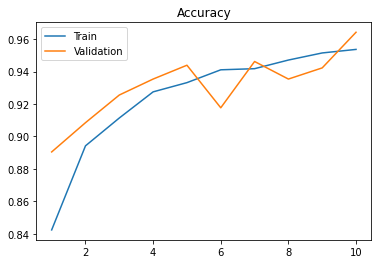

In [28]:
plt.plot(range(1,11),history2.history['accuracy'])
plt.plot(range(1,11),history2.history['val_accuracy'])
plt.legend(['Train','Validation'])
plt.title("Accuracy")

Text(0.5, 1.0, 'Loss')

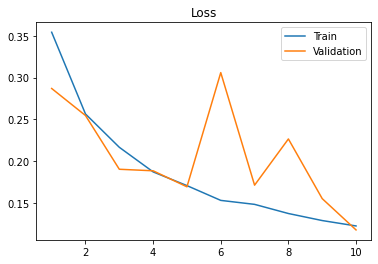

In [29]:
plt.plot(range(1,11),history2.history['loss'])
plt.plot(range(1,11),history2.history['val_loss'])
plt.legend(['Train','Validation'])
plt.title("Loss")

## Evaluate our model for our test set

In [31]:
score = model2.evaluate(test_gen)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

13/13 [==============================] - 48s 4s/step - loss: 0.2337 - accuracy: 0.9225
Test loss: 0.23365983366966248
Test accuracy: 0.9225000143051147


## We observe amazingly high scores of 0.92

Let's also save our model

In [32]:
model2.save('model_name.h5') #saving the model

In [58]:
def plot_image(i, predictions_array, true_label, img):
    true_label,img = true_label[i], img[0][0][i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_labels[predicted_label],
                                100*np.max(predictions_array),
                                class_labels[true_label]),
                                color=color)

## We are now selecting 6 negative images & 2 positive images from our test set to predict on

In [89]:
newdtest_file_names = [
    '0bb24183-8b59-48f1-8bbf-4d889976fc82.png',
    '0d9b1283-fc24-4fd3-a520-bc5d563e13e1.png',
    '0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d.png',
    '1afd6582-da9d-4e5a-a81f-62a188fe9366.png',
    '1c0a780d-1cac-4eee-b46d-470ecebc9ae0.png',
    '1cdba4ee-0bb8-421d-9a24-7febeb399729.png',
    'MIDRC-RICORD-1C-419639-003251-46647-0.png',
    'MIDRC-RICORD-1C-419639-001015-81591-0.png'
]

In [90]:
new_test_df = pd.DataFrame(newdtest_file_names, columns=['filename'])
new_test_df['class'] = ['Negative','Negative','Negative','Negative','Negative','Negative', 'Positive', 'Positive']
new_test_df

,filename,class
0,0bb24183-8b59-48f1-8bbf-4d889976fc82.png,Negative
1,0d9b1283-fc24-4fd3-a520-bc5d563e13e1.png,Negative
2,0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d.png,Negative
3,1afd6582-da9d-4e5a-a81f-62a188fe9366.png,Negative
4,1c0a780d-1cac-4eee-b46d-470ecebc9ae0.png,Negative
5,1cdba4ee-0bb8-421d-9a24-7febeb399729.png,Negative
6,MIDRC-RICORD-1C-419639-003251-46647-0.png,Positive
7,MIDRC-RICORD-1C-419639-001015-81591-0.png,Positive


In [91]:
new_test_gen = test_datagen.flow_from_dataframe(new_test_df, 
                                             directory=test_path, 
                                             x_col='filename',
                                             y_col='class', 
                                             target_size=target_size, 
                                             batch_size=batch_size, 
                                             color_mode='rgb', 
                                             validate_filenames=False)

Found 8 non-validated image filenames belonging to 2 classes.


In [93]:
new_predictions = probability_model.predict(new_test_gen)
new_predictions

array([[0.7310024 , 0.2689976 ],
       [0.73105437, 0.2689457 ],
       [0.62346464, 0.37653533],
       [0.73105556, 0.2689444 ],
       [0.27001187, 0.72998816],
       [0.73105675, 0.26894325],
       [0.7307117 , 0.2692883 ],
       [0.2689429 , 0.73105717]], dtype=float32)

## Let us look at the prediction and the confidence

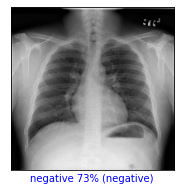

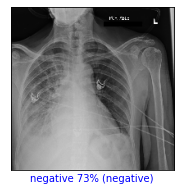

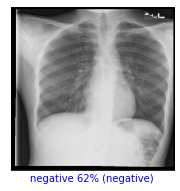

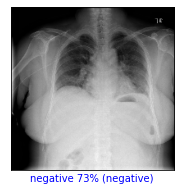

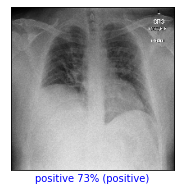

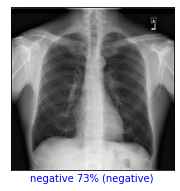

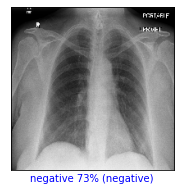

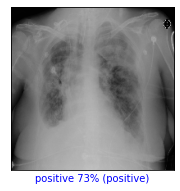

In [96]:
for i in range(8):
    plt.figure(figsize=(6,3))
    plot_image(i, new_predictions[i], new_test_df['true_labels'], new_test_gen)
plt.show()

# We have created a successful CNN that can predict Postive and Negative cases by looking correctly formatted X-Ray images!

In [66]:
class_labels = {0: 'negative', 1: 'positive'}